In [72]:
import os
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import MultiLabelBinarizer
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

**0. Import data & data clean**

In [73]:
df = pd.read_csv('../data/processed/shuffled_10_data.csv')
print(df.shape)
df.head()

(53130, 7)


,AC,PMID,Title,Abstract,Terms,Text_combined,batch_number
0,Q8NML3,17183211,"RamA, the transcriptional regulator of acetate...",The RamA protein represents a LuxR-type transc...,autoregulation,"RamA, the transcriptional regulator of acetate...",1
1,Q9SCZ4,17673660,The FERONIA receptor-like kinase mediates male...,"In flowering plants, signaling between the mal...",autophosphorylation,The FERONIA receptor-like kinase mediates male...,1
2,Q81WX1,12721629,The genome sequence of Bacillus anthracis Ames...,Bacillus anthracis is an endospore-forming bac...,NaN,The genome sequence of Bacillus anthracis Ames...,1
3,P14410,8521865,Phosphorylation of the N-terminal intracellula...,This paper reports the phosphorylation of the ...,NaN,Phosphorylation of the N-terminal intracellula...,1
4,P36898,14523231,Mutations in bone morphogenetic protein recept...,Brachydactyly (BD) type A2 is an autosomal dom...,autophosphorylation,Mutations in bone morphogenetic protein recept...,1


In [74]:
# clean text
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = " ".join([word.strip() for word in text.split() if word not in stop_words])
    return text

df['Text_Cleaned'] = df['Text_combined'].apply(clean_text)

# fill nan with 'non-autoregulatory'
df['Terms'] = df['Terms'].fillna('non-autoregulatory')

# keep only selected columns
columns_to_keep = ['batch_number','Text_Cleaned','Terms']
df_cleaned = df[columns_to_keep]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fiatlux/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [75]:
print(df_cleaned.shape)
df_cleaned.head()

(53130, 3)


,batch_number,Text_Cleaned,Terms
0,1,rama transcriptional regulator acetate metabol...,autoregulation
1,1,feronia receptorlike kinase mediates malefemal...,autophosphorylation
2,1,genome sequence bacillus anthracis ames compar...,non-autoregulatory
3,1,phosphorylation nterminal intracellular tail s...,non-autoregulatory
4,1,mutations bone morphogenetic protein receptor ...,autophosphorylation


In [76]:
# convert terms to list
df_cleaned['Terms_List'] = df_cleaned['Terms'].apply(
    lambda x: [term.strip() for term in x.split(',')]
)
df_cleaned['Terms_List'] = df_cleaned['Terms_List'].apply(lambda x: list(set(x)))

mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(df_cleaned['Terms_List'])
label_columns = mlb.classes_

labels_df = pd.DataFrame(labels, columns=label_columns)
existing_columns = [col for col in label_columns if col in df_cleaned.columns]
df_cleaned = df_cleaned.drop(columns=existing_columns, errors='ignore')
df_cleaned = pd.concat([df_cleaned, labels_df], axis=1)

/var/folders/1h/csb8qjzj1sv0jtrd6ccllm8c0000gn/T/ipykernel_83811/626586514.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Terms_List'] = df_cleaned['Terms'].apply(
/var/folders/1h/csb8qjzj1sv0jtrd6ccllm8c0000gn/T/ipykernel_83811/626586514.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Terms_List'] = df_cleaned['Terms_List'].apply(lambda x: list(set(x)))


In [77]:
print(df_cleaned.shape)
df_cleaned.head()

(53130, 19)


,batch_number,Text_Cleaned,Terms,Terms_List,autoactivation,autocatalysis,autocatalytic,autofeedback,autoinducer,autoinduction,autoinhibition,autoinhibitory,autokinase,autolysis,autophosphorylation,autoregulation,autoregulatory,autoubiquitination,non-autoregulatory
0,1,rama transcriptional regulator acetate metabol...,autoregulation,[autoregulation],0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,feronia receptorlike kinase mediates malefemal...,autophosphorylation,[autophosphorylation],0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,genome sequence bacillus anthracis ames compar...,non-autoregulatory,[non-autoregulatory],0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,phosphorylation nterminal intracellular tail s...,non-autoregulatory,[non-autoregulatory],0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1,mutations bone morphogenetic protein receptor ...,autophosphorylation,[autophosphorylation],0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [78]:
# check label distribution
test_df = df_cleaned[df_cleaned['batch_number'] == 1]
numeric_columns = test_df.select_dtypes(include=['int64', 'float64']).columns
label_counts = test_df[numeric_columns].sum(axis=0)
print(label_counts.sort_values(ascending=False))

batch_number           5313
non-autoregulatory     3542
autophosphorylation     844
autocatalytic           176
autoregulation          154
autoubiquitination      145
autoinhibition          135
autoregulatory           84
autoinducer              73
autolysis                70
autoinhibitory           60
autoactivation           22
autocatalysis            15
autofeedback             13
autoinduction            11
autokinase                8
dtype: int64


**1. Define Functions for the Model**

In [79]:
# Device Configuration
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Device being used: {device}")

# Load tokenizer and base model
tokenizer = AutoTokenizer.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext')
bert_model = AutoModel.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext')

Device being used: mps


In [80]:
# data splitting
def split_single_batch_data(batch_number, test_size=0.2, random_state=42):
    """
    Split data from a single batch into train and test sets using stratified sampling.
    Prints Train/Test sizes and Non-auto/Auto counts.
    """
    batch_df = df_cleaned[df_cleaned['batch_number'] == batch_number].copy()
    X = batch_df['Text_Cleaned']
    y = labels_df.loc[batch_df.index].values  # Ensure indexing alignment
    
    # calculate label distribution
    non_auto_count = len(batch_df[batch_df['Terms'] == 'non-autoregulatory'])
    auto_count = len(batch_df[batch_df['Terms'] != 'non-autoregulatory'])
    
    # split data
    msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    
    for train_idx, test_idx in msss.split(X, y):
        X_train = X.iloc[train_idx]
        X_test = X.iloc[test_idx]
        y_train = y[train_idx]
        y_test = y[test_idx]
    
    print(f"Batch {batch_number} | Train: {len(X_train)}, Test: {len(X_test)} | Non-auto: {non_auto_count}, Auto: {auto_count}")
    
    return X_train, X_test, y_train, y_test

In [81]:
# calculate class weights
def get_data_and_weights(batch_number):
    """
    Get data and calculate class weights for a specific batch.
    """
    X_train, X_test, y_train, y_test = split_single_batch_data(batch_number)
    
    # Calculate class weights
    pos_weights = []
    for i in range(y_train.shape[1]):
        neg_count = len(y_train) - np.sum(y_train[:, i])
        pos_count = np.sum(y_train[:, i])
        pos_weights.append(neg_count / pos_count if pos_count > 0 else 1.0)
    
    pos_weights = torch.FloatTensor(pos_weights).to(device)
    
    return X_train, X_test, y_train, y_test, pos_weights

In [82]:
# create dataset class
class PubMedDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(label)
        }

In [83]:
# create data loader
def create_dataset_and_loader(X_train, y_train, X_test, y_test, batch_size):
    train_dataset = PubMedDataset(X_train, y_train, tokenizer)
    test_dataset = PubMedDataset(X_test, y_test, tokenizer)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    return train_loader, test_loader

In [84]:
# create model
class PubMedBERTClassifier(nn.Module):
    def __init__(self, n_classes, dropout=0.1):
        super(PubMedBERTClassifier, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

In [85]:
# training function
def train_epoch(model, data_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    
    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(data_loader)

In [86]:
# Evaluation function
def evaluate(model, data_loader, criterion):
    """
    Evaluate the model and print key metrics in a compact format.
    """
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            
            # Apply sigmoid and threshold to get binary predictions
            predictions = (torch.sigmoid(outputs) > 0.5).float()
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    
    micro_f1 = f1_score(all_labels, all_predictions, average='micro')
    macro_f1 = f1_score(all_labels, all_predictions, average='macro')
    micro_precision = precision_score(all_labels, all_predictions, average='micro')
    micro_recall = recall_score(all_labels, all_predictions, average='micro')
    
    # Calculate average loss
    avg_loss = total_loss / len(data_loader)
    
    # Compact Metrics Output
    metrics = {
        'loss': avg_loss,
        'micro_f1': micro_f1,
        'macro_f1': macro_f1,
        'micro_precision': micro_precision,
        'micro_recall': micro_recall
    }
    
    print(f"  Loss: {avg_loss:.4f} | Micro F1: {micro_f1:.4f} | Macro F1: {macro_f1:.4f}")
    print(f"  Micro Precision: {micro_precision:.4f} | Micro Recall: {micro_recall:.4f}")
    
    return metrics

**2. Train model**

In [87]:
# model training loop
def train_model(batch_number, n_epochs=10, learning_rate=2e-5, batch_size=16):
    """
    Run training and evaluation for a single batch.
    Save the best model based on Micro F1 score.
    """
    # get data and calculate class weights
    X_train, X_test, y_train, y_test, pos_weights = get_data_and_weights(batch_number)
    
    print(f"\nProcessing Batch {batch_number} ...")
    
    # create dataLoader
    train_loader, test_loader = create_dataset_and_loader(X_train, y_train, X_test, y_test, batch_size)
    
    # initialize model, loss function and optimizer
    model = PubMedBERTClassifier(n_classes=y_train.shape[1]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    # track best model
    best_micro_f1 = -1.0
    best_model_path = f"../src/model/best_model_batch_{batch_number}.pt"
    
    # Training Loop
    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs} | Batch {batch_number}")
        
        # Training
        train_epoch(model, train_loader, optimizer, criterion)
        
        # Evaluation
        metrics = evaluate(model, test_loader, criterion)
        current_micro_f1 = metrics['micro_f1']
        
        # save best model
        if current_micro_f1 > best_micro_f1:
            best_micro_f1 = current_micro_f1
            torch.save(model.state_dict(), best_model_path)
            print(f"  New best model saved with Micro F1: {best_micro_f1:.4f}")
    
    print(f"Best model for Batch {batch_number} saved at {best_model_path}\n")

In [88]:
# run model for all batches
n_epochs = 10
learning_rate = 2e-5
batch_size = 16

# run 10 batches (range(1, 11))
for batch_num in range(1, 3):
    train_model(batch_number=batch_num, n_epochs=n_epochs, learning_rate=learning_rate, batch_size=batch_size)

Batch 1 | Train: 4248, Test: 1065 | Non-auto: 3542, Auto: 1771

Processing Batch 1 ...
Epoch 1/10 | Batch 1


KeyboardInterrupt: 

**3.Evaluation**

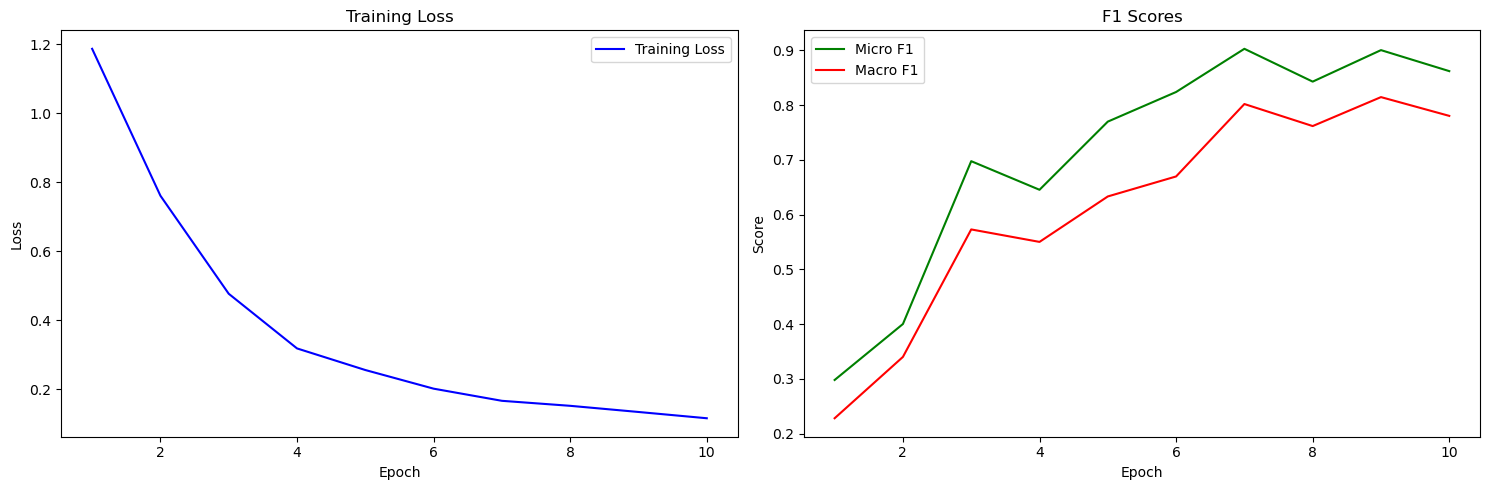

In [30]:
def plot_training_metrics(train_losses, test_metrics_history):
    """
    Plot metrics changes during training
    """
    epochs = range(1, len(train_losses) + 1)
    
    # Create figure with multiple subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot training loss
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot F1 scores
    micro_f1_scores = [metrics['micro_f1'] for metrics in test_metrics_history]
    macro_f1_scores = [metrics['macro_f1'] for metrics in test_metrics_history]
    
    ax2.plot(epochs, micro_f1_scores, 'g-', label='Micro F1')
    ax2.plot(epochs, macro_f1_scores, 'r-', label='Macro F1')
    ax2.set_title('F1 Scores')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Score')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()


plot_training_metrics(train_losses, test_metrics_history)

**4. Save this baseline model**

In [31]:
save_dir = '../src/model'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

model_save_path = os.path.join(save_dir, 'best_model.pt')
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'pos_weights': pos_weights,
    'label_columns': list(labels_df.columns)
}, model_save_path)

tokenizer_save_path = os.path.join(save_dir, 'tokenizer')
tokenizer.save_pretrained(tokenizer_save_path)

print(f"Model saved to {model_save_path}")
print(f"Tokenizer saved to {tokenizer_save_path}")

Model saved to ../src/model/best_model.pt
Tokenizer saved to ../src/model/tokenizer


In [34]:
print("Best Model Parameters:")
print("-" * 50)
print("\n1. Base Model:")
print("PubMedBERT (microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext)")

print("\n2. Model Architecture:")
print(f"- Dropout rate: {model.dropout.p}")
print(f"- Hidden size: {model.bert.config.hidden_size}")
print(f"- Number of classes: {model.classifier.out_features}")
print(f"- Number of layers: {len(model.bert.encoder.layer)} BERT layers")

print("\n3. Training Parameters:")
print(f"- Batch size: {batch_size}")
print(f"- Learning rate: {optimizer.param_groups[0]['lr']}")
print("- Optimizer: AdamW")
print("- Loss function: BCEWithLogitsLoss with class weights")
print(f"- Max sequence length: {train_dataset.max_length}")

print("\n4. Model Size:")
print(f"- Total parameters: {total_params:,}")
print(f"- Trainable parameters: {trainable_params:,}")

# Find best metrics from test_metrics_history
best_metrics = max(test_metrics_history, key=lambda x: x['micro_f1'])
best_epoch = test_metrics_history.index(best_metrics) + 1

print("\n5. Best Performance Metrics:")
print(f"- Best Micro F1: {best_metrics['micro_f1']:.4f} (achieved at epoch {best_epoch})")
print(f"- Corresponding Micro Precision: {best_metrics['micro_precision']:.4f}")
print(f"- Corresponding Micro Recall: {best_metrics['micro_recall']:.4f}")
print(f"- Corresponding Macro F1: {best_metrics['macro_f1']:.4f}")

Best Model Parameters:
--------------------------------------------------

1. Base Model:
PubMedBERT (microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext)

2. Model Architecture:
- Dropout rate: 0.1
- Hidden size: 768
- Number of classes: 14
- Number of layers: 12 BERT layers

3. Training Parameters:
- Batch size: 16
- Learning rate: 2e-05
- Optimizer: AdamW
- Loss function: BCEWithLogitsLoss with class weights
- Max sequence length: 512

4. Model Size:
- Total parameters: 109,493,006
- Trainable parameters: 109,493,006

5. Best Performance Metrics:
- Best Micro F1: 0.9027 (achieved at epoch 7)
- Corresponding Micro Precision: 0.8541
- Corresponding Micro Recall: 0.9571
- Corresponding Macro F1: 0.8018
